# Mystique FMCG — Supply Chain Planning

**Stack:** Python · Pandas · NumPy · Matplotlib · Seaborn · Google Sheets API

**Scope:** Warehouse assignment → Route optimization → Inventory management → Demand forecasting  
**Data:** 2 warehouses, 50 distribution houses, 30 days of demand history — Bangladesh

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import seaborn as sns
import math, warnings

warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.facecolor':'white','axes.facecolor':'#f8f9fa','font.family':'sans-serif'})
sns.set_palette("husl")

In [2]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

In [3]:
spreadsheet = gc.open('Mystique_Data')

warehouses_df          = pd.DataFrame(spreadsheet.worksheet('Warehouses').get_all_records())
distribution_houses_df = pd.DataFrame(spreadsheet.worksheet('Distribution_Houses').get_all_records())
historical_demand_df   = pd.DataFrame(spreadsheet.worksheet('Historical_Demand').get_all_records())
warehouse_distances_df = pd.DataFrame(spreadsheet.worksheet('Warehouse_Distances').get_all_records())

for name, df in [('Warehouses', warehouses_df), ('Distribution Houses', distribution_houses_df),
                 ('Historical Demand', historical_demand_df), ('Warehouse Distances', warehouse_distances_df)]:
    print(f'{name}: {df.shape}  |  nulls: {df.isnull().sum().sum()}')

Warehouses: (2, 4)  |  nulls: 0
Distribution Houses: (50, 5)  |  nulls: 0
Historical Demand: (1500, 3)  |  nulls: 0
Warehouse Distances: (100, 3)  |  nulls: 0


## 2. Exploratory Data Analysis

In [4]:
print(warehouses_df)
print()
print(distribution_houses_df.describe())

  warehouse_id                name  latitude  longitude
0           W1  Northern Warehouse     25.75      89.25
1           W2  Southern Warehouse     22.35      90.35

        latitude  longitude  avg_daily_demand
count  50.000000  50.000000         50.000000
mean   23.855099  90.478805         73.400000
std     1.477510   1.324627         30.683373
min    21.503890  88.031280         20.000000
25%    22.564702  89.405675         51.250000
50%    23.738515  90.458025         72.000000
75%    25.044060  91.521992        104.750000
max    26.349550  92.464950        119.000000


In [5]:
print(f"DHs: {distribution_houses_df.shape[0]}")
print(f"Demand range: {distribution_houses_df['avg_daily_demand'].min()}–{distribution_houses_df['avg_daily_demand'].max()} units/day")
print(f"Total demand: {distribution_houses_df['avg_daily_demand'].sum()} units/day")
print(f"Historical period: {historical_demand_df['date'].iloc[0]} → {historical_demand_df['date'].iloc[-1]}  ({historical_demand_df['date'].nunique()} days)")

DHs: 50
Demand range: 20–119 units/day
Total demand: 3670 units/day
Historical period: 2025-06-18 → 2025-07-17  (30 days)


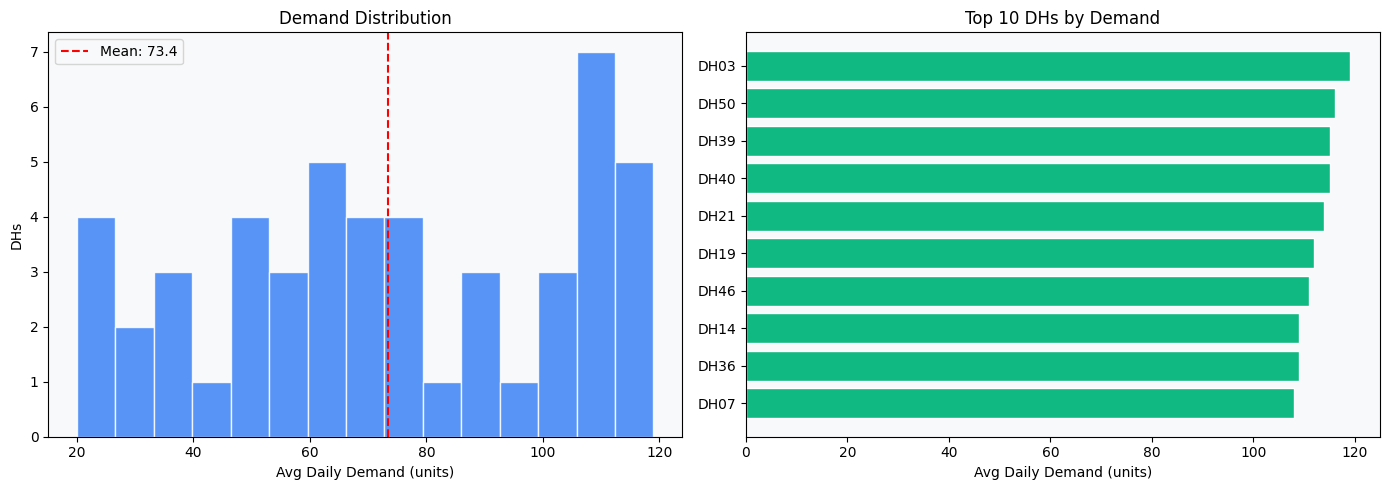

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(distribution_houses_df['avg_daily_demand'], bins=15, color='#3b82f6', edgecolor='white', alpha=0.85)
axes[0].axvline(distribution_houses_df['avg_daily_demand'].mean(), color='red', linestyle='--',
                label=f"Mean: {distribution_houses_df['avg_daily_demand'].mean():.1f}")
axes[0].set(xlabel='Avg Daily Demand (units)', ylabel='DHs', title='Demand Distribution')
axes[0].legend()

top10 = distribution_houses_df.nlargest(10, 'avg_daily_demand')
axes[1].barh(top10['distribution_id'], top10['avg_daily_demand'], color='#10b981', edgecolor='white')
axes[1].invert_yaxis()
axes[1].set(xlabel='Avg Daily Demand (units)', title='Top 10 DHs by Demand')

plt.tight_layout()
plt.show()

## 3. Warehouse Assignment

Assign each DH to its nearest warehouse by road distance. Flag outliers.

In [7]:
distance_pivot = warehouse_distances_df.pivot(
    index='distribution_id', columns='warehouse_id', values='distance_km'
).reset_index()
distance_pivot.columns = ['distribution_id', 'W1_distance', 'W2_distance']

dh_analysis = distribution_houses_df.merge(distance_pivot, on='distribution_id', how='left')
dh_analysis['nearest_warehouse']  = np.where(dh_analysis['W1_distance'] < dh_analysis['W2_distance'], 'W1', 'W2')
dh_analysis['assigned_distance']  = dh_analysis[['W1_distance', 'W2_distance']].min(axis=1)
dh_analysis['distance_difference'] = abs(dh_analysis['W1_distance'] - dh_analysis['W2_distance'])

dh_analysis.head()

,distribution_id,name,latitude,longitude,avg_daily_demand,W1_distance,W2_distance,nearest_warehouse,assigned_distance,distance_difference
0,DH01,Distribution House 1,23.37270,92.27821,91,404.26,228.00,W2,228.00,176.26
1,DH02,Distribution House 2,24.49329,88.70208,102,149.78,291.04,W1,149.78,141.26
2,DH03,Distribution House 3,21.99987,90.06662,119,423.59,48.55,W2,48.55,375.04
3,DH04,Distribution House 4,22.21433,90.92900,72,427.24,61.53,W2,61.53,365.71
4,DH05,Distribution House 5,26.34955,91.74599,57,258.46,465.09,W1,258.46,206.63


In [8]:
W1_DHs = dh_analysis[dh_analysis['nearest_warehouse'] == 'W1']
W2_DHs = dh_analysis[dh_analysis['nearest_warehouse'] == 'W2']

for label, subset in [('W1 (Northern)', W1_DHs), ('W2 (Southern)', W2_DHs)]:
    print(f"{label}: {len(subset)} DHs | {subset['avg_daily_demand'].sum()} units/day "
          f"({subset['avg_daily_demand'].sum()/35000*100:.1f}% of capacity) | "
          f"avg dist {subset['assigned_distance'].mean():.1f} km")

# Flag outliers
print(f"\nDHs >300km from assigned warehouse: {len(dh_analysis[dh_analysis['assigned_distance'] > 300])}")
print(dh_analysis[dh_analysis['assigned_distance'] > 300][['distribution_id','nearest_warehouse','assigned_distance']])
print(f"\nDHs within 50km of both warehouses: {len(dh_analysis[dh_analysis['distance_difference'] < 50])}")

W1 (Northern): 22 DHs | 1575 units/day (4.5% of capacity) | avg dist 163.0 km
W2 (Southern): 28 DHs | 2095 units/day (6.0% of capacity) | avg dist 152.3 km

DHs >300km from assigned warehouse: 1
   distribution_id nearest_warehouse  assigned_distance
24            DH25                W2             307.87

DHs within 50km of both warehouses: 5


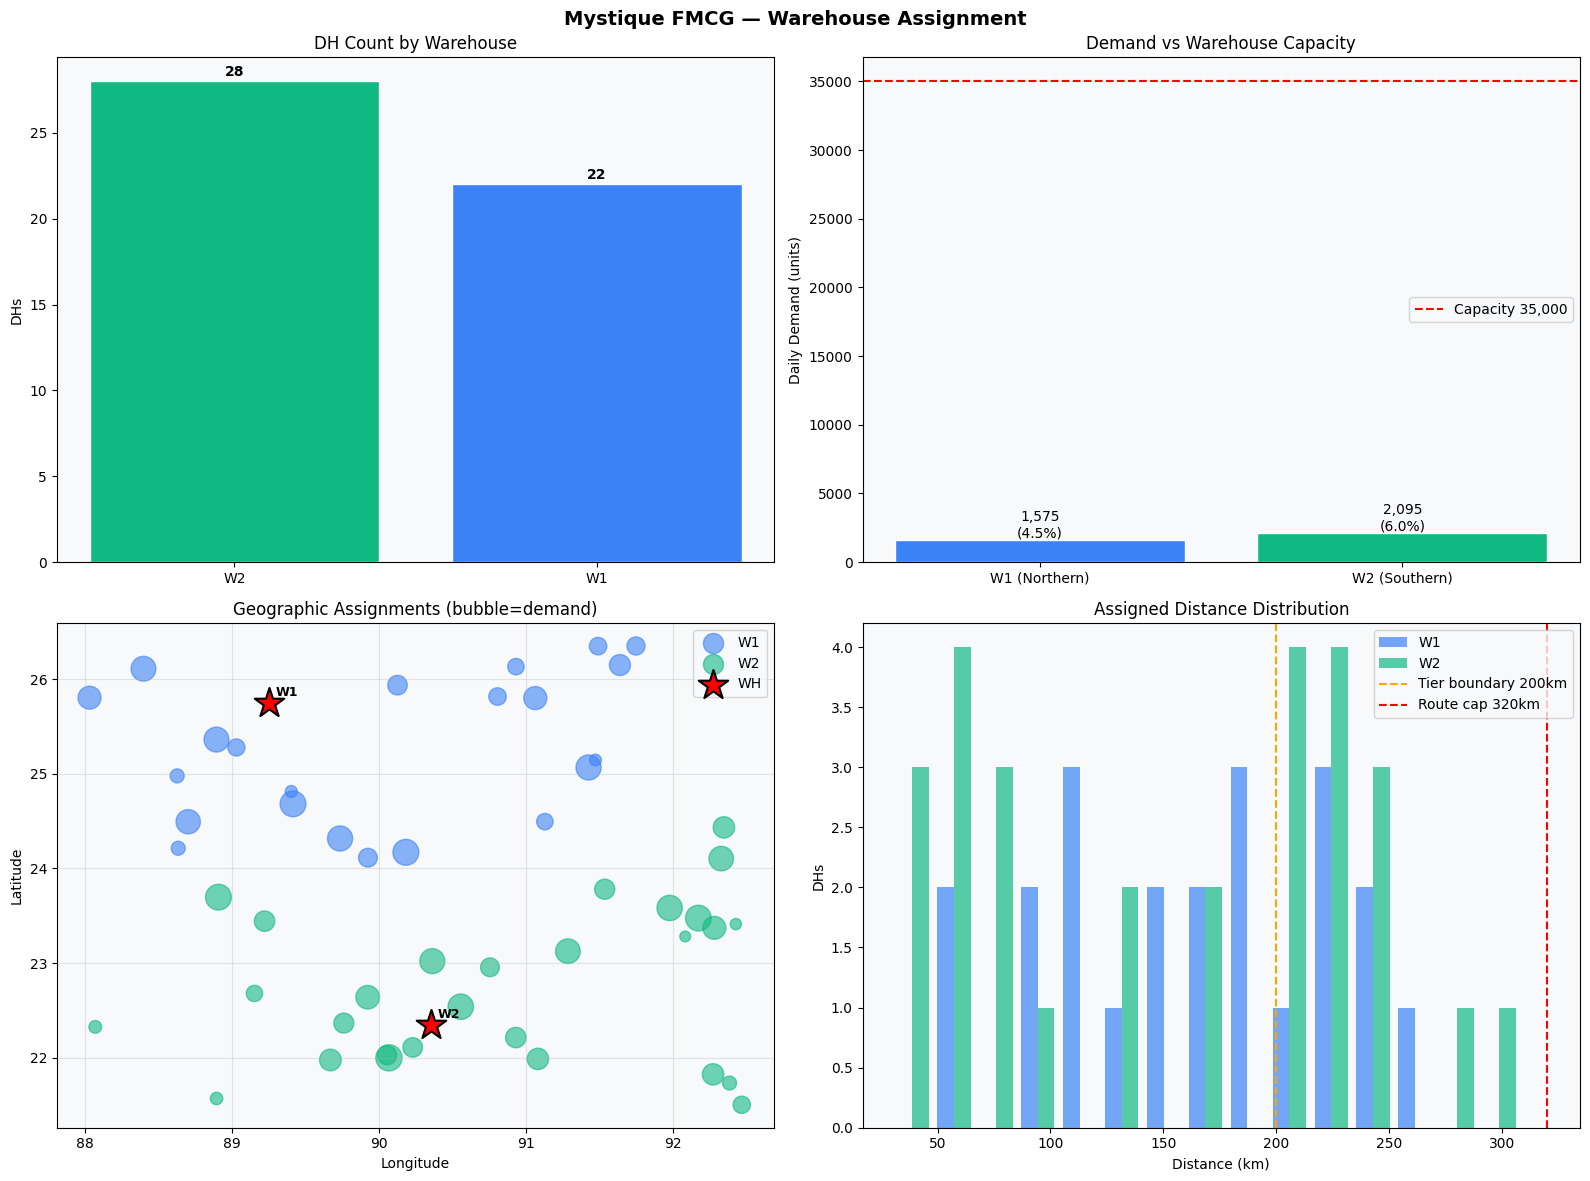

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Mystique FMCG — Warehouse Assignment', fontsize=14, fontweight='bold')
cmap = {'W1': '#3b82f6', 'W2': '#10b981'}

# Count
ax = axes[0,0]
counts = dh_analysis['nearest_warehouse'].value_counts()
ax.bar(counts.index, counts.values, color=[cmap[k] for k in counts.index], edgecolor='white')
[ax.text(i, v+.3, str(v), ha='center', fontweight='bold') for i,v in enumerate(counts.values)]
ax.set(ylabel='DHs', title='DH Count by Warehouse')

# Demand vs capacity
ax = axes[0,1]
demands = [W1_DHs['avg_daily_demand'].sum(), W2_DHs['avg_daily_demand'].sum()]
bars = ax.bar(['W1 (Northern)','W2 (Southern)'], demands, color=['#3b82f6','#10b981'], edgecolor='white')
ax.axhline(35000, color='red', linestyle='--', label='Capacity 35,000')
ax.legend()
[ax.text(b.get_x()+b.get_width()/2, b.get_height()+200, f'{d:,}\n({d/35000*100:.1f}%)', ha='center')
 for b,d in zip(bars, demands)]
ax.set(ylabel='Daily Demand (units)', title='Demand vs Warehouse Capacity')

# Map
ax = axes[1,0]
for wh, col in cmap.items():
    s = dh_analysis[dh_analysis['nearest_warehouse'] == wh]
    ax.scatter(s['longitude'], s['latitude'], s=s['avg_daily_demand']*3, alpha=0.6, color=col, label=wh)
ax.scatter(warehouses_df['longitude'], warehouses_df['latitude'],
           s=500, marker='*', color='red', edgecolors='black', linewidths=1.5, zorder=5, label='WH')
for _, r in warehouses_df.iterrows():
    ax.annotate(r['warehouse_id'], (r['longitude'], r['latitude']), xytext=(5,5),
                textcoords='offset points', fontsize=9, fontweight='bold')
ax.set(xlabel='Longitude', ylabel='Latitude', title='Geographic Assignments (bubble=demand)')
ax.legend(); ax.grid(alpha=0.3)

# Distance histogram
ax = axes[1,1]
ax.hist([W1_DHs['assigned_distance'], W2_DHs['assigned_distance']], bins=15,
        label=['W1','W2'], color=['#3b82f6','#10b981'], alpha=0.7)
ax.axvline(200, color='orange', linestyle='--', label='Tier boundary 200km')
ax.axvline(320, color='red',    linestyle='--', label='Route cap 320km')
ax.set(xlabel='Distance (km)', ylabel='DHs', title='Assigned Distance Distribution')
ax.legend()

plt.tight_layout(); plt.show()

## 4. Route Optimization

CVRP heuristic. Constraints: 800 unit capacity, 320 km max, 38 km/h avg speed, 20 min/stop loading, 8h shift.

Three iterations below — each one exposed a problem that motivated the next design change.

In [10]:
def calculate_distance(lat1, lon1, lat2, lon2):
    R = 6371
    lat1_r, lat2_r = math.radians(lat1), math.radians(lat2)
    a = math.sin(math.radians(lat2-lat1)/2)**2 + math.cos(lat1_r)*math.cos(lat2_r)*math.sin(math.radians(lon2-lon1)/2)**2
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

# Quick check against stored road distances
dh05 = dh_analysis[dh_analysis['distribution_id'] == 'DH05'].iloc[0]
calc = calculate_distance(25.75, 89.25, dh05['latitude'], dh05['longitude'])
print(f"DH05 haversine: {calc:.2f} km  |  stored: {dh05['W1_distance']:.2f} km  |  diff: {abs(calc-dh05['W1_distance']):.2f} km")

DH05 haversine: 258.10 km  |  stored: 258.46 km  |  diff: 0.36 km


### V1 — Farthest-first seed

Intuition: commit to the longest legs first to reduce deadhead. Greedily fill remaining capacity with nearest neighbours.

In [11]:
def create_routes_v1(warehouse_id, dh_data, warehouse_data):
    TRUCK_CAP, MAX_DIST, SPEED, LOAD_T = 800, 320, 38, 20/60
    wh = warehouse_data[warehouse_data['warehouse_id'] == warehouse_id].iloc[0]
    wh_lat, wh_lon = wh['latitude'], wh['longitude']
    unassigned = dh_data[dh_data['nearest_warehouse'] == warehouse_id].to_dict('records')
    routes, n = [], 1

    while unassigned:
        seed = max(unassigned, key=lambda x: x['assigned_distance'])  # farthest first
        route = {'id': f"{warehouse_id}_R{n}", 'dhs': [seed['distribution_id']],
                 'demand': seed['avg_daily_demand'], 'stops': 1,
                 'dist': calculate_distance(wh_lat, wh_lon, seed['latitude'], seed['longitude'])}
        unassigned.remove(seed)
        cur_lat, cur_lon = seed['latitude'], seed['longitude']

        while unassigned:
            cands = [d for d in unassigned if route['demand'] + d['avg_daily_demand'] <= TRUCK_CAP]
            if not cands: break
            nearest, d_next = min([(d, calculate_distance(cur_lat, cur_lon, d['latitude'], d['longitude']))
                                    for d in cands], key=lambda x: x[1])
            ret = calculate_distance(nearest['latitude'], nearest['longitude'], wh_lat, wh_lon)
            if route['dist'] + d_next + ret > MAX_DIST: break
            route['dhs'].append(nearest['distribution_id']); route['demand'] += nearest['avg_daily_demand']
            route['dist'] += d_next; route['stops'] += 1
            cur_lat, cur_lon = nearest['latitude'], nearest['longitude']
            unassigned.remove(nearest)

        route['dist'] += calculate_distance(cur_lat, cur_lon, wh_lat, wh_lon)
        route['time'] = round(route['dist']/SPEED + route['stops']*LOAD_T, 2)
        route['util'] = round(route['demand']/TRUCK_CAP*100, 1)
        route['cost'] = round(1400 + route['dist']*12, 0)
        routes.append(route); n += 1
    return routes

all_v1 = create_routes_v1('W1', dh_analysis, warehouses_df) + create_routes_v1('W2', dh_analysis, warehouses_df)
print(f"Routes: {len(all_v1)} | Avg stops: {sum(r['stops'] for r in all_v1)/len(all_v1):.1f} | "
      f"Avg util: {sum(r['util'] for r in all_v1)/len(all_v1):.1f}% | "
      f"Max time: {max(r['time'] for r in all_v1):.1f}h | "
      f"Within shift: {sum(1 for r in all_v1 if r['time']<=8)}/{len(all_v1)}")

Routes: 35 | Avg stops: 1.4 | Avg util: 13.1% | Max time: 16.6h | Within shift: 3/35


**Result:** 35 routes, 13% avg utilisation, max route 16.5h — far exceeds shift limit.

Farthest-first commits the full distance budget on the outbound leg, leaving no room for additional stops. Almost every route is a single-stop run.

### V2 — Closest-first, full round-trip evaluation

Flip the seed: start from nearest DH and build outward. Also fix distance check to use full round-trip rather than just the incremental leg.

In [12]:
def create_routes_v2(warehouse_id, dh_data, warehouse_data):
    TRUCK_CAP, MAX_DIST, SPEED, LOAD_T, MAX_T = 800, 320, 38, 20/60, 8
    wh = warehouse_data[warehouse_data['warehouse_id'] == warehouse_id].iloc[0]
    assigned = dh_data[dh_data['nearest_warehouse'] == warehouse_id].copy()
    assigned = assigned.sort_values('assigned_distance').reset_index(drop=True)
    unassigned, routes, n = set(assigned.index), [], 1

    while unassigned:
        route_idx = [min(unassigned)]; unassigned.remove(route_idx[0])
        improved = True
        while improved and unassigned:
            improved = False; best, best_inc = None, float('inf')
            cur_d = sum(assigned.loc[i,'avg_daily_demand'] for i in route_idx)
            for cand in unassigned:
                if cur_d + assigned.loc[cand,'avg_daily_demand'] > TRUCK_CAP: continue
                test = route_idx + [cand]
                d = assigned.loc[test[0],'assigned_distance']
                for i in range(len(test)-1):
                    a, b = assigned.loc[test[i]], assigned.loc[test[i+1]]
                    d += calculate_distance(a['latitude'],a['longitude'],b['latitude'],b['longitude'])
                d += assigned.loc[test[-1],'assigned_distance']
                if d <= MAX_DIST and d/SPEED + len(test)*LOAD_T <= MAX_T:
                    last = assigned.loc[route_idx[-1]]; cdh = assigned.loc[cand]
                    inc = calculate_distance(last['latitude'],last['longitude'],cdh['latitude'],cdh['longitude'])
                    if inc < best_inc: best_inc, best = inc, cand
            if best: route_idx.append(best); unassigned.remove(best); improved = True

        dem = sum(assigned.loc[i,'avg_daily_demand'] for i in route_idx)
        d = assigned.loc[route_idx[0],'assigned_distance']
        for i in range(len(route_idx)-1):
            a,b = assigned.loc[route_idx[i]], assigned.loc[route_idx[i+1]]
            d += calculate_distance(a['latitude'],a['longitude'],b['latitude'],b['longitude'])
        d += assigned.loc[route_idx[-1],'assigned_distance']
        t = d/SPEED + len(route_idx)*LOAD_T
        routes.append({'id':f"{warehouse_id}_R{n}",'dhs':[assigned.loc[i,'distribution_id'] for i in route_idx],
                       'stops':len(route_idx),'demand':dem,'dist':round(d,2),'time':round(t,2),
                       'util':round(dem/TRUCK_CAP*100,1),'cost':round(1400+d*12,0)}); n+=1
    return routes

all_v2 = create_routes_v2('W1', dh_analysis, warehouses_df) + create_routes_v2('W2', dh_analysis, warehouses_df)
print(f"Routes: {len(all_v2)} | Avg stops: {sum(r['stops'] for r in all_v2)/len(all_v2):.1f} | "
      f"Avg util: {sum(r['util'] for r in all_v2)/len(all_v2):.1f}% | "
      f"Max time: {max(r['time'] for r in all_v2):.1f}h | "
      f"Within shift: {sum(1 for r in all_v2 if r['time']<=8)}/{len(all_v2)}")

Routes: 38 | Avg stops: 1.3 | Avg util: 12.1% | Max time: 16.5h | Within shift: 9/38


**Better clustering, but remote DHs still a problem.** DHs beyond 200 km produce near-empty single-stop routes — the round-trip alone exhausts the 320 km / 8h budget.

The algorithm isn't wrong; the routing model is wrong for that geography. DHs beyond ~200 km need a different delivery strategy entirely.

### Distance distribution — justifying the tier split

In [13]:
print("DHs by 50km brackets:")
for lo in range(0, 350, 50):
    n = len(dh_analysis[(dh_analysis['assigned_distance'] > lo) & (dh_analysis['assigned_distance'] <= lo+50)])
    print(f"  {lo:>3}–{lo+50:<3} km : {'█'*n} {n}")

DAILY_THRESHOLD = 200
nearby_dhs = dh_analysis[dh_analysis['assigned_distance'] <= DAILY_THRESHOLD].copy()
remote_dhs = dh_analysis[dh_analysis['assigned_distance'] >  DAILY_THRESHOLD].copy()
print(f"\nTier 1 ≤{DAILY_THRESHOLD}km: {len(nearby_dhs)} DHs | {nearby_dhs['avg_daily_demand'].sum()} units/day")
print(f"Tier 2 >{DAILY_THRESHOLD}km: {len(remote_dhs)} DHs | {remote_dhs['avg_daily_demand'].sum()} units/day")

DHs by 50km brackets:
    0–50  km : ████ 4
   50–100 km : ███████████ 11
  100–150 km : ███████ 7
  150–200 km : ██████████ 10
  200–250 km : ███████████████ 15
  250–300 km : ██ 2
  300–350 km : █ 1

Tier 1 ≤200km: 32 DHs | 2455 units/day
Tier 2 >200km: 18 DHs | 1215 units/day


### V3 (final) — Two-tier, relaxed constraints for Tier 1

Route only Tier 1 DHs (≤200 km) in daily runs. Relax distance cap to 400 km and shift to 9h so two mid-range DHs can share a route. Tier 2 handled separately on a scheduled bulk model.

In [14]:
def create_daily_routes_v3(warehouse_id, dh_data, warehouse_data, threshold=200):
    # Key changes from V2:
    #   - Tier 1 scope only (≤threshold km)
    #   - MAX_DIST 400km: two 160km DHs can now share a route
    #   - MAX_SHIFT 9h: adds realistic buffer; overtime above 8h is costed
    TRUCK_CAP, MAX_DIST, SPEED, LOAD_T, MAX_T = 800, 400, 38, 20/60, 9
    FIXED, VAR, OT_RATE = 1400, 12, 600

    wh = warehouse_data[warehouse_data['warehouse_id'] == warehouse_id].iloc[0]
    nearby = dh_data[(dh_data['nearest_warehouse']==warehouse_id) &
                     (dh_data['assigned_distance']<=threshold)].copy()
    nearby = nearby.sort_values('assigned_distance').reset_index(drop=True)
    unassigned, routes, n = set(nearby.index), [], 1
    print(f"  {warehouse_id}: {len(nearby)} Tier 1 DHs")

    while unassigned:
        route_idx = [min(unassigned)]; unassigned.remove(route_idx[0])
        improved = True
        while improved and unassigned:
            improved = False; best, best_inc = None, float('inf')
            cur_d = sum(nearby.loc[i,'avg_daily_demand'] for i in route_idx)
            for cand in unassigned:
                if cur_d + nearby.loc[cand,'avg_daily_demand'] > TRUCK_CAP: continue
                test = route_idx + [cand]
                d = nearby.loc[test[0],'assigned_distance']
                for i in range(len(test)-1):
                    a,b = nearby.loc[test[i]], nearby.loc[test[i+1]]
                    d += calculate_distance(a['latitude'],a['longitude'],b['latitude'],b['longitude'])
                d += nearby.loc[test[-1],'assigned_distance']
                if d<=MAX_DIST and d/SPEED+len(test)*LOAD_T<=MAX_T:
                    last=nearby.loc[route_idx[-1]]; cdh=nearby.loc[cand]
                    inc=calculate_distance(last['latitude'],last['longitude'],cdh['latitude'],cdh['longitude'])
                    if inc<best_inc: best_inc,best=inc,cand
            if best: route_idx.append(best); unassigned.remove(best); improved=True

        dem=sum(nearby.loc[i,'avg_daily_demand'] for i in route_idx)
        d=nearby.loc[route_idx[0],'assigned_distance']
        for i in range(len(route_idx)-1):
            a,b=nearby.loc[route_idx[i]],nearby.loc[route_idx[i+1]]
            d+=calculate_distance(a['latitude'],a['longitude'],b['latitude'],b['longitude'])
        d+=nearby.loc[route_idx[-1],'assigned_distance']
        t=d/SPEED+len(route_idx)*LOAD_T; ot=max(0,t-8)
        cost=FIXED+VAR*d+(ot*OT_RATE if ot>0 else 0)
        routes.append({'route_id':f"{warehouse_id}_Daily_R{n}",'warehouse':warehouse_id,'tier':'Daily',
                       'dhs':[nearby.loc[i,'distribution_id'] for i in route_idx],'stops':len(route_idx),
                       'total_demand':dem,'total_distance':round(d,2),'total_time':round(t,2),
                       'total_cost':round(cost,2),'capacity_utilization':round(dem/TRUCK_CAP*100,1),
                       'overtime_hours':round(ot,2)}); n+=1
    return routes

w1_daily = create_daily_routes_v3('W1', dh_analysis, warehouses_df)
w2_daily = create_daily_routes_v3('W2', dh_analysis, warehouses_df)
all_daily = w1_daily + w2_daily

  W1: 16 Tier 1 DHs
  W2: 16 Tier 1 DHs


### Iteration comparison

In [15]:
results = []
for routes, label in [(all_v1, 'V1 — farthest-first, all DHs, 320km/8h'),
                      (all_v2, 'V2 — closest-first, all DHs, 320km/8h'),
                      (all_daily,'V3 — closest-first, Tier 1 only, 400km/9h ✓')]:
    uk = 'util' if 'util' in routes[0] else 'capacity_utilization'
    n = len(routes)
    results.append({'Version': label, 'Routes': n,
                    'Avg Stops': round(sum(r['stops'] for r in routes)/n,1),
                    'Avg Util %': round(sum(r[uk] for r in routes)/n,1),
                    'Max Time h': round(max(r['time'] if 'time' in r else r['total_time'] for r in routes),1),
                    'Within Shift': sum(1 for r in routes if (r.get('time') or r.get('total_time',0))<=8),
                    'Daily Cost ৳': f"{sum(r.get('cost') or r.get('total_cost',0) for r in routes):,.0f}"})

pd.DataFrame(results).to_string(index=False) and print(pd.DataFrame(results).to_string(index=False))

                                    Version  Routes  Avg Stops  Avg Util %  Max Time h  Within Shift Daily Cost ৳
     V1 — farthest-first, all DHs, 320km/8h      35        1.4        13.1        16.6             3      216,325
      V2 — closest-first, all DHs, 320km/8h      38        1.3        12.1        16.5             9      226,134
V3 — closest-first, Tier 1 only, 400km/9h ✓      19        1.7        16.2        10.8             7      108,016


### Tier 2 — remote DHs (>200 km)

Daily runs aren't viable. Recommended model: bulk delivery 3×/week (Mon/Wed/Fri), each truck carries 3 days of stock. DHs need storage for 5–7 days.

In [16]:
for wh, subset in [('W1', remote_dhs[remote_dhs['nearest_warehouse']=='W1']),
                   ('W2', remote_dhs[remote_dhs['nearest_warehouse']=='W2'])]:
    print(f"{wh}: {len(subset)} remote DHs | avg {subset['assigned_distance'].mean():.0f} km | "
          f"{subset['avg_daily_demand'].sum()} units/day | "
          f"{subset['avg_daily_demand'].sum()*3} units per delivery run")

total_daily_cost = sum(r['total_cost'] for r in all_daily)
print(f"\nTier 1 summary: {len(all_daily)} routes | "
      f"avg {sum(r['capacity_utilization'] for r in all_daily)/len(all_daily):.1f}% util | "
      f"৳{total_daily_cost:,.0f}/day | ৳{total_daily_cost*300:,.0f}/year")
print(f"Fleet gap: need {len(all_daily)} trucks, have 6 → {len(all_daily)-6} additional required")

W1: 6 remote DHs | avg 239 km | 366 units/day | 1098 units per delivery run
W2: 12 remote DHs | avg 235 km | 849 units/day | 2547 units per delivery run

Tier 1 summary: 19 routes | avg 16.2% util | ৳108,016/day | ৳32,404,734/year
Fleet gap: need 19 trucks, have 6 → 13 additional required


## 5. Inventory Optimization

Safety stock, ROP, EOQ using classical inventory theory. Lead time 1 day (Tier 1) / 2 days (Tier 2). Service level 95% (Z=1.65).

In [17]:
demand_stats = historical_demand_df.groupby('distribution_id')['demand_units'].agg(
    avg_demand='mean', std_demand='std', min_demand='min', max_demand='max'
).round(2).reset_index()

inventory_analysis = dh_analysis.merge(demand_stats, on='distribution_id')
inventory_analysis['cv'] = (inventory_analysis['std_demand'] / inventory_analysis['avg_demand']).round(3)

print(inventory_analysis[['distribution_id','avg_demand','std_demand','cv']].head(10).to_string(index=False))
print(f"\nCV summary — Low(<0.15): {(inventory_analysis['cv']<0.15).sum()} | "
      f"Med(0.15-0.25): {((inventory_analysis['cv']>=0.15)&(inventory_analysis['cv']<0.25)).sum()} | "
      f"High(≥0.25): {(inventory_analysis['cv']>=0.25).sum()}")

distribution_id  avg_demand  std_demand    cv
           DH01       91.07       10.53 0.116
           DH02      101.20        9.23 0.091
           DH03      120.23        9.55 0.079
           DH04       73.73       11.27 0.153
           DH05       55.90        9.75 0.174
           DH06       50.40       11.41 0.226
           DH07      108.97        8.67 0.080
           DH08       61.73        7.95 0.129
           DH09       33.13        7.14 0.216
           DH10       70.63       12.04 0.170

CV summary — Low(<0.15): 28 | Med(0.15-0.25): 15 | High(≥0.25): 7


In [18]:
Z, H_DAY, S_ORD = 1.65, 0.50, 800
H_ANN = H_DAY * 365

inventory_analysis['lead_time_days'] = inventory_analysis['assigned_distance'].apply(lambda x: 1 if x<=200 else 2)
inventory_analysis['safety_stock']   = (Z * inventory_analysis['std_demand'] * np.sqrt(inventory_analysis['lead_time_days'])).round(0)
inventory_analysis['reorder_point']  = (inventory_analysis['avg_demand']*inventory_analysis['lead_time_days'] + inventory_analysis['safety_stock']).round(0)
inventory_analysis['annual_demand']  = inventory_analysis['avg_demand'] * 300
inventory_analysis['eoq']            = np.sqrt(2*inventory_analysis['annual_demand']*S_ORD/H_ANN).round(0)
inventory_analysis['avg_inventory']  = (inventory_analysis['eoq']/2 + inventory_analysis['safety_stock']).round(0)
inventory_analysis['annual_holding_cost']  = (inventory_analysis['avg_inventory'] * H_ANN).round(0)
inventory_analysis['orders_per_year']      = (inventory_analysis['annual_demand'] / inventory_analysis['eoq']).round(1)
inventory_analysis['annual_ordering_cost'] = (inventory_analysis['orders_per_year'] * S_ORD).round(0)
inventory_analysis['total_annual_inv_cost']= (inventory_analysis['annual_holding_cost']+inventory_analysis['annual_ordering_cost']).round(0)

total_ss   = inventory_analysis['safety_stock'].sum()
total_avg  = inventory_analysis['avg_inventory'].sum()
total_cost = inventory_analysis['total_annual_inv_cost'].sum()
print(f"Safety stock: {total_ss:,.0f} units | Avg inventory: {total_avg:,.0f} units | "
      f"Days of supply: {total_avg/inventory_analysis['avg_demand'].sum():.1f}")
print(f"Annual inv cost: ৳{total_cost:,.0f}  (holding ৳{inventory_analysis['annual_holding_cost'].sum():,.0f} + ordering ৳{inventory_analysis['annual_ordering_cost'].sum():,.0f})")

Safety stock: 940 units | Avg inventory: 11,659 units | Days of supply: 3.2
Annual inv cost: ৳4,084,327  (holding ৳2,127,767 + ordering ৳1,956,560)


In [19]:
# ABC classification by cumulative demand contribution
inv_s = inventory_analysis.sort_values('avg_demand', ascending=False).reset_index(drop=True)
inv_s['cum_pct'] = inv_s['avg_demand'].cumsum() / inv_s['avg_demand'].sum() * 100
inv_s['abc_class'] = inv_s['cum_pct'].apply(lambda x: 'A' if x<=70 else ('B' if x<=90 else 'C'))
inventory_analysis = inventory_analysis.merge(inv_s[['distribution_id','abc_class']], on='distribution_id')

# Storage capacity check
inventory_analysis['max_inventory']     = inventory_analysis['eoq'] + inventory_analysis['safety_stock']
inventory_analysis['storage_capacity']  = inventory_analysis['avg_daily_demand'].apply(lambda x: 1500 if x>100 else (1000 if x>=50 else 700))
inventory_analysis['capacity_utilization'] = (inventory_analysis['max_inventory']/inventory_analysis['storage_capacity']*100).round(1)

print("ABC summary:")
print(inventory_analysis.groupby('abc_class').agg(
    DHs=('distribution_id','count'), Demand=('avg_demand','sum'),
    Inv_Cost=('total_annual_inv_cost','sum')).assign(Demand_pct=lambda df: (df.Demand/df.Demand.sum()*100).round(1)))
print(f"\nOver-capacity DHs: {(inventory_analysis['capacity_utilization']>100).sum()}")
print(f"Avg storage utilization: {inventory_analysis['capacity_utilization'].mean():.1f}%")

ABC summary:
           DHs   Demand   Inv_Cost  Demand_pct
abc_class                                     
A           26  2551.13  2493130.0        69.5
B           12   722.94   909700.0        19.7
C           12   396.10   681497.0        10.8

Over-capacity DHs: 0
Avg storage utilization: 42.4%


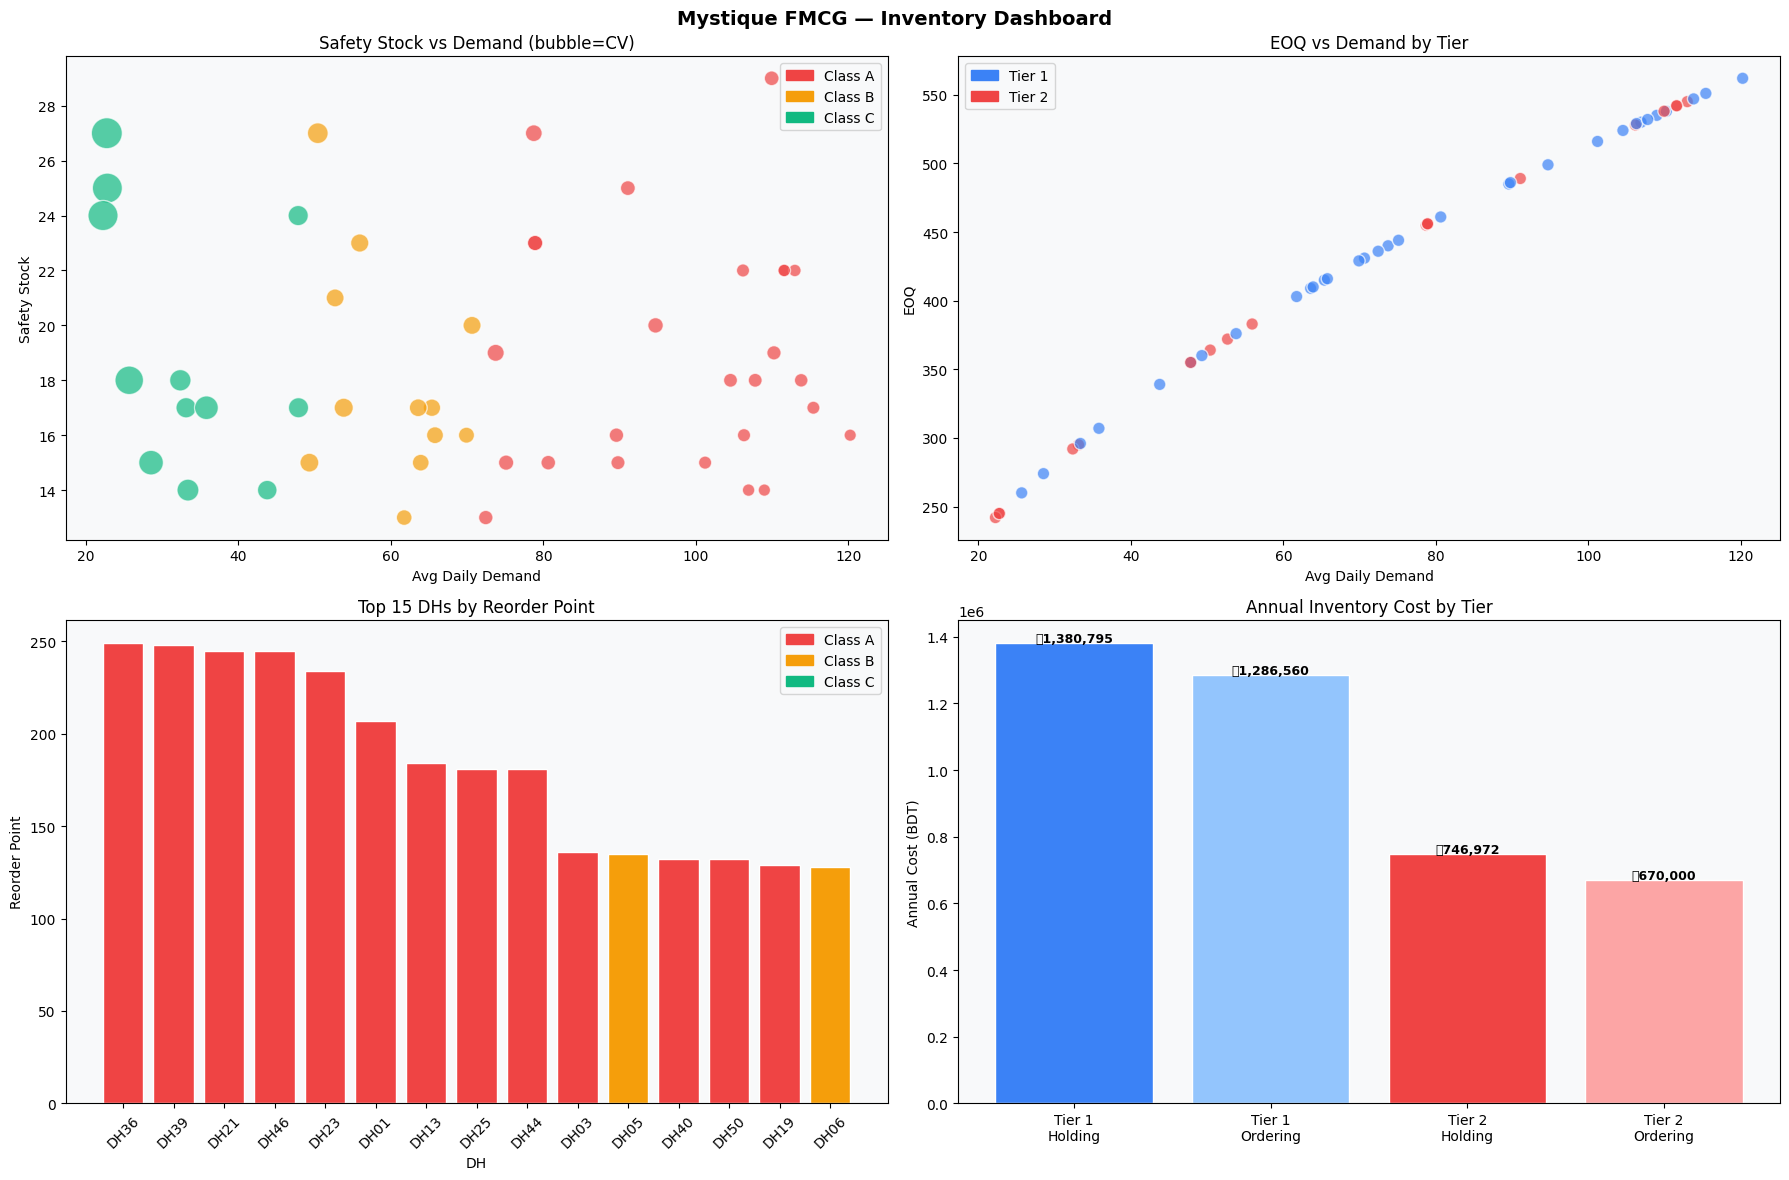

In [20]:
abc_colors = {'A':'#ef4444','B':'#f59e0b','C':'#10b981'}
legend_patches = [mpatches.Patch(color=v, label=f'Class {k}') for k,v in abc_colors.items()]
tier1_inv = inventory_analysis[inventory_analysis['lead_time_days']==1]
tier2_inv = inventory_analysis[inventory_analysis['lead_time_days']==2]
high_var  = inventory_analysis[inventory_analysis['cv']>0.25]

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Mystique FMCG — Inventory Dashboard', fontsize=14, fontweight='bold')

ax = axes[0,0]
ax.scatter(inventory_analysis['avg_demand'], inventory_analysis['safety_stock'],
           c=[abc_colors[c] for c in inventory_analysis['abc_class']],
           s=inventory_analysis['cv']*1000, alpha=0.7, edgecolors='white')
ax.set(xlabel='Avg Daily Demand', ylabel='Safety Stock', title='Safety Stock vs Demand (bubble=CV)')
ax.legend(handles=legend_patches)

ax = axes[0,1]
tier_c = ['#3b82f6' if d<=200 else '#ef4444' for d in inventory_analysis['assigned_distance']]
ax.scatter(inventory_analysis['avg_demand'], inventory_analysis['eoq'], c=tier_c, s=80, alpha=0.7, edgecolors='white')
ax.legend(handles=[mpatches.Patch(color='#3b82f6',label='Tier 1'),mpatches.Patch(color='#ef4444',label='Tier 2')])
ax.set(xlabel='Avg Daily Demand', ylabel='EOQ', title='EOQ vs Demand by Tier')

ax = axes[1,0]
rop = inventory_analysis.nlargest(15,'reorder_point')
ax.bar(rop['distribution_id'], rop['reorder_point'], color=[abc_colors[c] for c in rop['abc_class']], edgecolor='white')
ax.tick_params(axis='x', rotation=45)
ax.set(xlabel='DH', ylabel='Reorder Point', title='Top 15 DHs by Reorder Point')
ax.legend(handles=legend_patches)

ax = axes[1,1]
cats = ['Tier 1\nHolding','Tier 1\nOrdering','Tier 2\nHolding','Tier 2\nOrdering']
vals = [tier1_inv['annual_holding_cost'].sum(), tier1_inv['annual_ordering_cost'].sum(),
        tier2_inv['annual_holding_cost'].sum(), tier2_inv['annual_ordering_cost'].sum()]
bars = ax.bar(cats, vals, color=['#3b82f6','#93c5fd','#ef4444','#fca5a5'], edgecolor='white')
[ax.text(b.get_x()+b.get_width()/2, b.get_height()+3000, f'৳{v:,.0f}', ha='center', fontsize=9, fontweight='bold')
 for b,v in zip(bars,vals)]
ax.set(ylabel='Annual Cost (BDT)', title='Annual Inventory Cost by Tier')

plt.tight_layout(); plt.show()

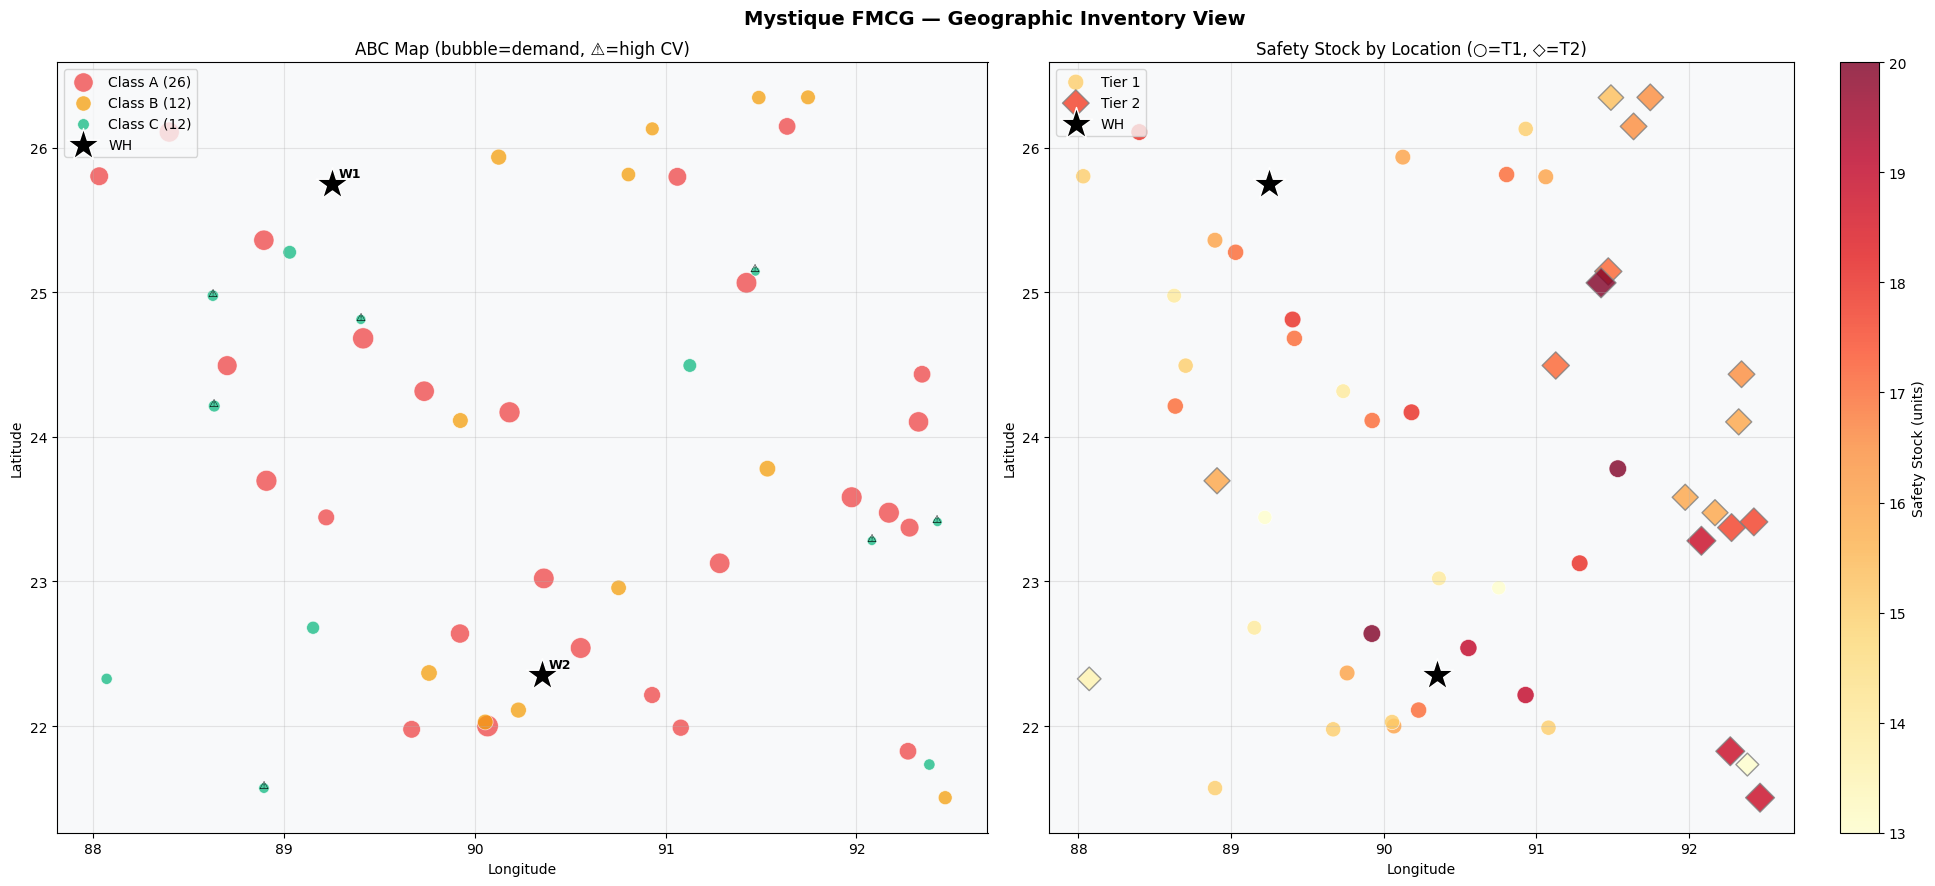

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(20, 9))
fig.suptitle('Mystique FMCG — Geographic Inventory View', fontsize=14, fontweight='bold')

ax = axes[0]
for cls, col in abc_colors.items():
    s = inventory_analysis[inventory_analysis['abc_class']==cls]
    ax.scatter(s['longitude'], s['latitude'], c=col, s=s['avg_demand']*2, alpha=0.75,
               label=f'Class {cls} ({len(s)})', edgecolors='white', linewidths=0.5)
for _, row in high_var.iterrows():
    ax.annotate('⚠️', (row['longitude'], row['latitude']), fontsize=8, ha='center')
ax.scatter(warehouses_df['longitude'], warehouses_df['latitude'],
           s=600, marker='*', c='black', edgecolors='white', linewidths=1, label='WH', zorder=5)
for _, r in warehouses_df.iterrows():
    ax.annotate(r['warehouse_id'], (r['longitude'],r['latitude']), xytext=(5,5),
                textcoords='offset points', fontsize=9, fontweight='bold')
ax.set(xlabel='Longitude', ylabel='Latitude', title='ABC Map (bubble=demand, ⚠️=high CV)')
ax.legend(loc='upper left'); ax.grid(alpha=0.3)

ax = axes[1]
sc = ax.scatter(tier1_inv['longitude'], tier1_inv['latitude'], c=tier1_inv['safety_stock'],
                cmap='YlOrRd', s=tier1_inv['safety_stock']*8, alpha=0.8,
                marker='o', label='Tier 1', edgecolors='white', linewidths=0.5)
ax.scatter(tier2_inv['longitude'], tier2_inv['latitude'], c=tier2_inv['safety_stock'],
           cmap='YlOrRd', s=tier2_inv['safety_stock']*8, alpha=0.8,
           marker='D', label='Tier 2', edgecolors='gray', linewidths=1)
plt.colorbar(sc, ax=ax, label='Safety Stock (units)')
ax.scatter(warehouses_df['longitude'], warehouses_df['latitude'],
           s=600, marker='*', c='black', edgecolors='white', linewidths=1, label='WH', zorder=5)
ax.set(xlabel='Longitude', ylabel='Latitude', title='Safety Stock by Location (○=T1, ◇=T2)')
ax.legend(loc='upper left'); ax.grid(alpha=0.3)

plt.tight_layout(); plt.show()

## 6. Demand Forecasting

Three models compared: Moving Average (MA), Weighted MA (WMA), Exponential Smoothing (ES).  
Train: first 25 days. Test: last 5 days. Best model per DH used for the 7-day forward forecast.

In [22]:
historical_demand_df['date'] = pd.to_datetime(historical_demand_df['date'])
historical_demand_df = historical_demand_df.sort_values(['distribution_id','date']).reset_index(drop=True)

train_data = historical_demand_df.groupby('distribution_id').apply(lambda x: x.iloc[:25]).reset_index(drop=True)
test_data  = historical_demand_df.groupby('distribution_id').apply(lambda x: x.iloc[25:]).reset_index(drop=True)
print(f"Train: {len(train_data)} records | Test: {len(test_data)} records")

Train: 1250 records | Test: 250 records


In [23]:
def ma_forecast(data, w=7, days=5):
    return [round(data['demand_units'].tail(w).mean(), 1)] * days

def wma_forecast(data, w=7, days=5):
    vals = data['demand_units'].tail(w).values
    wts  = np.arange(1, w+1) / np.arange(1, w+1).sum()
    return [round(np.dot(vals, wts), 1)] * days

def es_forecast(data, alpha=0.3, days=5):
    s = data['demand_units'].values[0]
    for d in data['demand_units'].values[1:]:
        s = alpha*d + (1-alpha)*s
    return [round(s, 1)] * days

# Validate on DH01
dh = 'DH01'
tr = train_data[train_data['distribution_id']==dh]
te = test_data[test_data['distribution_id']==dh]
print(f"{dh} — actual: {te['demand_units'].values}")
print(f"  MA:  {ma_forecast(tr)}  WMA: {wma_forecast(tr)}  ES:  {es_forecast(tr)}")

DH01 — actual: [85 91 85 75 91]
  MA:  [np.float64(92.7), np.float64(92.7), np.float64(92.7), np.float64(92.7), np.float64(92.7)]  WMA: [np.float64(92.8), np.float64(92.8), np.float64(92.8), np.float64(92.8), np.float64(92.8)]  ES:  [np.float64(92.6), np.float64(92.6), np.float64(92.6), np.float64(92.6), np.float64(92.6)]


In [24]:
rows = []
for dh_id in historical_demand_df['distribution_id'].unique():
    tr  = train_data[train_data['distribution_id']==dh_id]
    te  = test_data[test_data['distribution_id']==dh_id]
    for day_i, actual in enumerate(te['demand_units'].values):
        rows.append({'distribution_id':dh_id,'day':day_i+1,'actual':actual,
                     'ma':ma_forecast(tr)[day_i],'wma':wma_forecast(tr)[day_i],'es':es_forecast(tr)[day_i]})

fc = pd.DataFrame(rows)
for m in ['ma','wma','es']:
    fc[f'{m}_err']     = abs(fc['actual'] - fc[m])
    fc[f'{m}_pct_err'] = fc[f'{m}_err'] / fc['actual'] * 100

ma_mae,wma_mae,es_mae   = fc['ma_err'].mean(), fc['wma_err'].mean(), fc['es_err'].mean()
ma_mape,wma_mape,es_mape= fc['ma_pct_err'].mean(), fc['wma_pct_err'].mean(), fc['es_pct_err'].mean()

print(f"{'Model':<22} {'MAE':>8} {'RMSE':>8} {'MAPE':>8}")
print("-"*48)
for name,mae,rmse,mape in [
    ('Moving Average',    ma_mae,  np.sqrt((fc['ma_err']**2).mean()),  ma_mape),
    ('Weighted MA',       wma_mae, np.sqrt((fc['wma_err']**2).mean()), wma_mape),
    ('Exp Smoothing',     es_mae,  np.sqrt((fc['es_err']**2).mean()),  es_mape)]:
    print(f"{name:<22} {mae:>8.2f} {rmse:>8.2f} {mape:>7.1f}%")

dh_acc = fc.groupby('distribution_id').agg(MA=('ma_err','mean'),WMA=('wma_err','mean'),ES=('es_err','mean')).round(2)
dh_acc['best'] = dh_acc[['MA','WMA','ES']].idxmin(axis=1)
print(f"\nModel wins: {dh_acc['best'].value_counts().to_dict()}")

Model                       MAE     RMSE     MAPE
------------------------------------------------
Moving Average             8.64    10.79    29.9%
Weighted MA                8.79    10.90    28.3%
Exp Smoothing              8.74    10.83    27.8%

Model wins: {'MA': 26, 'ES': 19, 'WMA': 5}


In [25]:
future = []
for dh_id in historical_demand_df['distribution_id'].unique():
    all_d = historical_demand_df[historical_demand_df['distribution_id']==dh_id]
    best  = dh_acc.loc[dh_id,'best']
    fvals = {'MA':ma_forecast,'WMA':wma_forecast,'ES':es_forecast}[best](all_d, days=7)
    inv   = inventory_analysis[inventory_analysis['distribution_id']==dh_id].iloc[0]
    future.append({'distribution_id':dh_id,'model':best,**{f'day{i+1}':fvals[i] for i in range(7)},
                   'weekly_total':sum(fvals),'avg_daily':round(np.mean(fvals),1),
                   'rop':inv['reorder_point'],'ss':inv['safety_stock'],'eoq':inv['eoq']})

future_df = pd.DataFrame(future)
print(future_df[['distribution_id','model','avg_daily','weekly_total','rop','eoq']].head(15).to_string(index=False))
print(f"\nSystem 7-day total: {future_df['weekly_total'].sum():,.0f} units")

distribution_id model  avg_daily  weekly_total   rop   eoq
           DH01    ES       86.6         606.2 207.0 489.0
           DH02    ES      102.6         718.2 116.0 516.0
           DH03    MA      117.3         821.1 136.0 562.0
           DH04    ES       70.7         494.9  93.0 440.0
           DH05    MA       57.1         399.7 135.0 383.0
           DH06   WMA       52.5         367.5 128.0 364.0
           DH07    MA      110.3         772.1 123.0 535.0
           DH08   WMA       57.9         405.3  75.0 403.0
           DH09    ES       34.3         240.1  83.0 295.0
           DH10    MA       66.9         468.3  91.0 431.0
           DH11    ES       12.5          87.5  71.0 245.0
           DH12    ES       92.2         645.4 106.0 485.0
           DH13    ES       83.8         586.6 184.0 455.0
           DH14   WMA      107.4         751.8 121.0 530.0
           DH15    MA       77.3         541.1  90.0 444.0

System 7-day total: 25,495 units


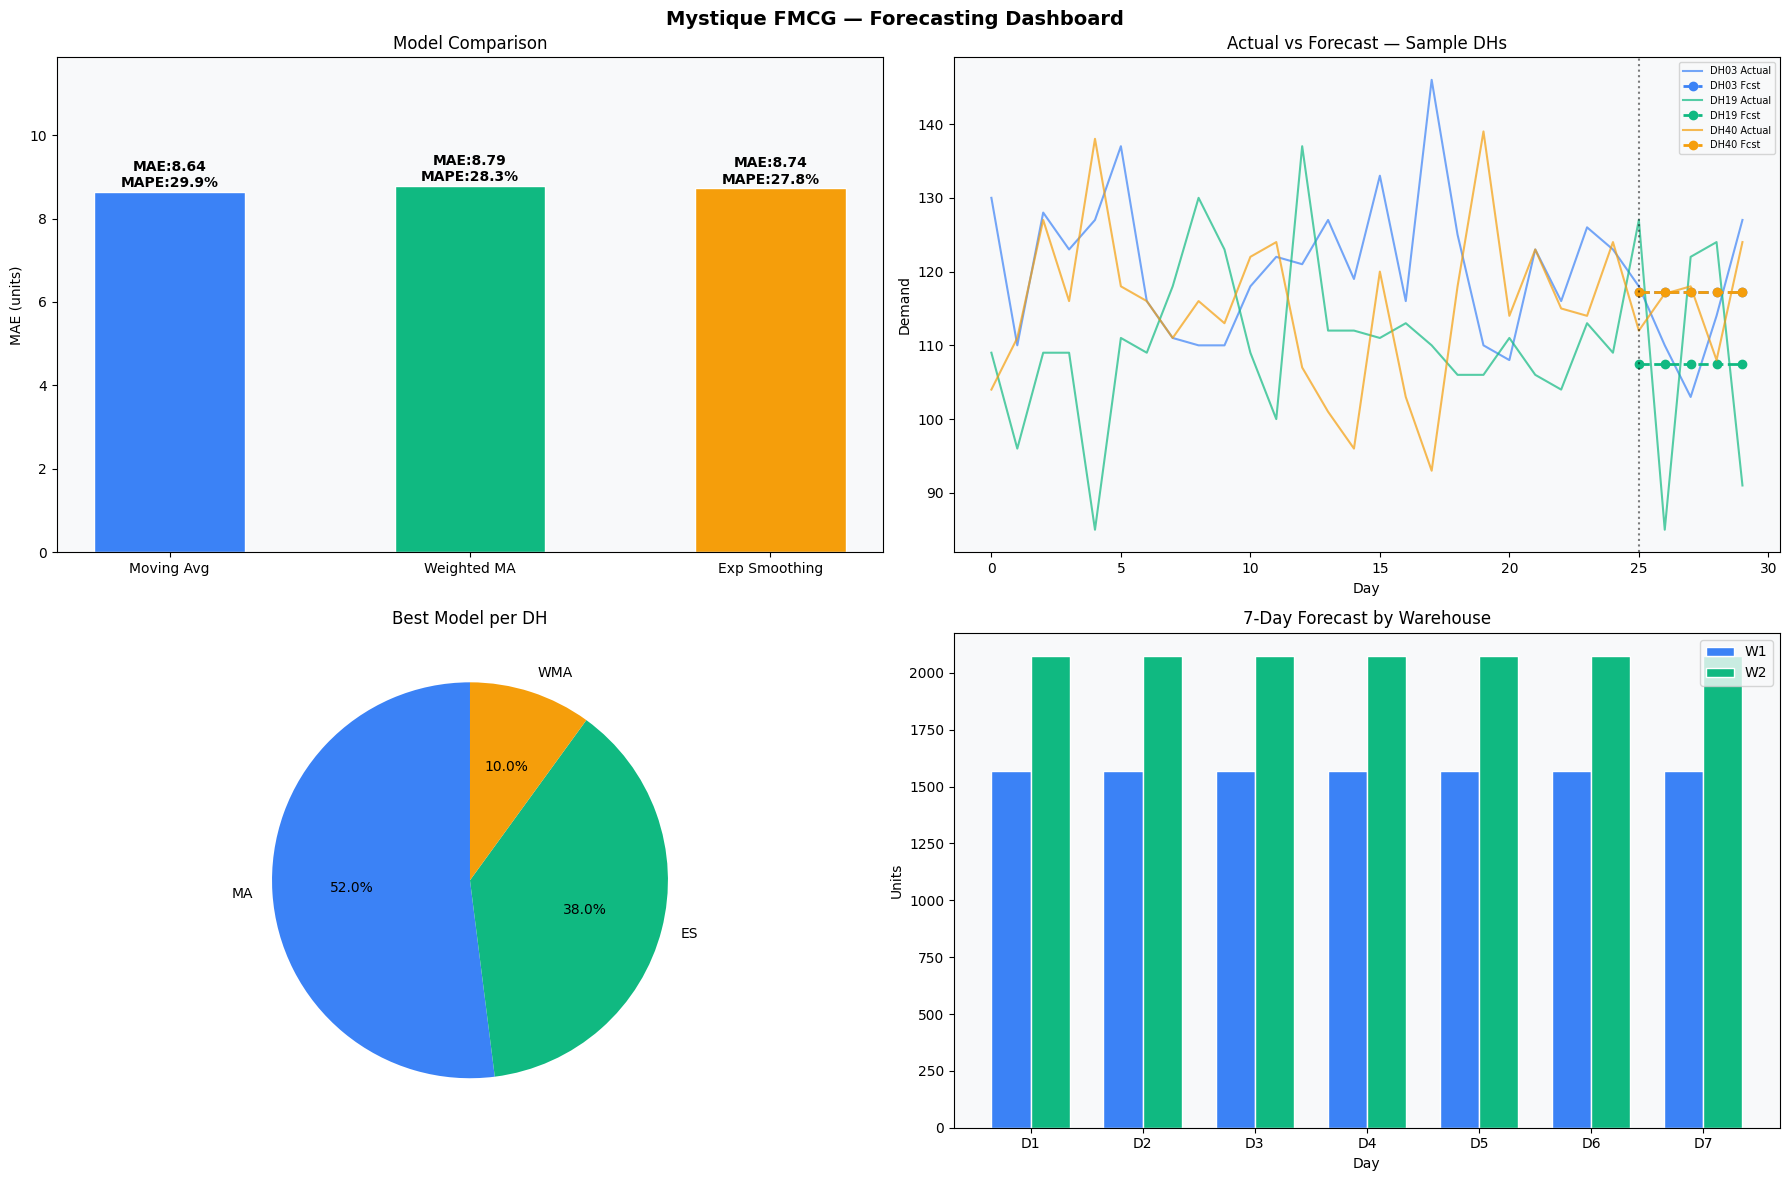

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Mystique FMCG — Forecasting Dashboard', fontsize=14, fontweight='bold')
mcols = ['#3b82f6','#10b981','#f59e0b']

ax = axes[0,0]
maes = [ma_mae,wma_mae,es_mae]; mapes = [ma_mape,wma_mape,es_mape]
bars = ax.bar(['Moving Avg','Weighted MA','Exp Smoothing'], maes, color=mcols, edgecolor='white', width=0.5)
[ax.text(b.get_x()+b.get_width()/2, b.get_height()+0.1, f'MAE:{m:.2f}\nMAPE:{p:.1f}%', ha='center', fontsize=10, fontweight='bold')
 for b,m,p in zip(bars,maes,mapes)]
ax.set(ylabel='MAE (units)', title='Model Comparison'); ax.set_ylim(0, max(maes)*1.35)

ax = axes[0,1]
for dh_id, col in zip(['DH03','DH19','DH40'], mcols):
    d = historical_demand_df[historical_demand_df['distribution_id']==dh_id]
    ax.plot(range(len(d)), d['demand_units'].values, color=col, alpha=0.7, lw=1.5, label=f'{dh_id} Actual')
    fc_val = future_df[future_df['distribution_id']==dh_id].iloc[0]['day1']
    ax.plot(range(25,30), [fc_val]*5, color=col, ls='--', lw=2, marker='o', label=f'{dh_id} Fcst')
ax.axvline(25, color='black', ls=':', alpha=0.5); ax.legend(fontsize=7)
ax.set(xlabel='Day', ylabel='Demand', title='Actual vs Forecast — Sample DHs')

ax = axes[1,0]
wins = dh_acc['best'].value_counts()
ax.pie(wins.values, labels=wins.index, autopct='%1.1f%%', colors=mcols[:len(wins)], startangle=90)
ax.set_title('Best Model per DH')

ax = axes[1,1]
fwh = future_df.merge(dh_analysis[['distribution_id','nearest_warehouse']], on='distribution_id')
days = [f'D{i}' for i in range(1,8)]
w1f = [fwh[fwh['nearest_warehouse']=='W1'][f'day{i}'].sum() for i in range(1,8)]
w2f = [fwh[fwh['nearest_warehouse']=='W2'][f'day{i}'].sum() for i in range(1,8)]
x = np.arange(7)
ax.bar(x-0.175, w1f, 0.35, label='W1', color='#3b82f6', edgecolor='white')
ax.bar(x+0.175, w2f, 0.35, label='W2', color='#10b981', edgecolor='white')
ax.set(xlabel='Day', ylabel='Units', title='7-Day Forecast by Warehouse', xticks=x, xticklabels=days)
ax.legend()

plt.tight_layout(); plt.show()

## 7. Export Outputs

In [27]:
pd.DataFrame([{
    'Route_ID':r['route_id'],'Warehouse':r['warehouse'],'DHs':','.join(r['dhs']),
    'Stops':r['stops'],'Demand':r['total_demand'],'Util_%':r['capacity_utilization'],
    'Distance_km':r['total_distance'],'Time_h':r['total_time'],'Cost_BDT':r['total_cost']
} for r in all_daily]).to_csv('route_summary.csv', index=False)

inventory_analysis[['distribution_id','nearest_warehouse','abc_class','avg_demand','std_demand',
                     'cv','lead_time_days','safety_stock','reorder_point','eoq','avg_inventory',
                     'capacity_utilization','total_annual_inv_cost']].to_csv('inventory_parameters.csv', index=False)

future_df.to_csv('7day_forecast.csv', index=False)
print("✓ route_summary.csv  ✓ inventory_parameters.csv  ✓ 7day_forecast.csv")

✓ route_summary.csv  ✓ inventory_parameters.csv  ✓ 7day_forecast.csv
